In [1]:
# system  
import os
from tqdm.auto import tqdm
import pickle
import joblib

# data
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# Azure
import azureml.automl.core
from azureml.automl.core.shared import logging_utilities, log_server
from azureml.telemetry import INSTRUMENTATION_KEY
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType

In [2]:
# point this at your folder of raster covariates
raster_folder  = '/media/nick/2TB Working 2/Projects/Nulla ML test/Cov_nulla - for Nick'
# what raster file format are your covariates?
input_file_ext = '.tif'
# this is your predicted raster layer
output_raster_file = '/media/nick/2TB Working 2/Projects/Nulla ML test/Nulla_nick_13-4-2021_DL.tif'
# this is the path to the 'model.pkl' file downloaded from Azure
model_path = '/media/nick/2TB Working 2/Projects/Nulla ML test/DL model v5 DL/AutoML880de06d80/model.pkl'

In [3]:
print("Raster folder valid?",os.path.isdir(raster_folder))
print("Model file valid?",os.path.isfile(model_path))
if os.path.isfile(output_raster_file):
    print('WARNING the output file already exists....')

Raster folder valid? True
Model file valid? True
WARNING the output file already exists....


In [4]:
# if your rasters have a NaN value (or multible) set it here
raster_nan_values = [-3.3999999521443642e+38]
# the max number of nan values at one location before that location is masked out
nan_threshold = 1
# what data type do you want the export file to be? (this must be compatible with numpy and rasterio/gdal)
# uint8 should be fine upto 256 classes
data_dtype = 'uint8'

In [5]:
# what classes do you have? the raster will be labeled in this order
classes = ['Bindii','Eucch','Nulbr3','Nulbr1','Nulbr2','Spwgr']
# this must be an int value compatible with your 'data_dtype'
export_raster_nan = 255 
print("Your export raster NaN value is",export_raster_nan)

Your export raster NaN value is 255


In [6]:
# search folder and all sub folders for 'input_file_ext' files
raster_list = []
for root, dirs, files in os.walk(raster_folder):
    for file in files:
        if file.endswith(input_file_ext):
            raster_list.append(os.path.join(root, file))
            
print('Number of rasters found',len(raster_list))

Number of rasters found 100


In [7]:
# loop over each raster, extract the data and place in dataframe
# this is rather RAM hungry, you may need to pre tile the data if it will not fit
# make blank dataframe
joined_data = pd.DataFrame()
# this could be multithreaded but it's normally pretty quick as is
# loop over rasters
for raster_path in tqdm(raster_list):
#     grab the raster name to use as column heading
    raster_file_name = os.path.basename(raster_path).replace(input_file_ext,'')
#     open raster with rasterio and read first band
    geotiff_open = rasterio.open(raster_path).read(1)
#     convert data into 1D numpy array and convert to float32 to avoid Skilearn errors
    raster_as_1D_array = np.array(geotiff_open).flatten().astype('float32')
#     replace raster nan values with numpy nan values
    if len(raster_nan_values)>0:
        for raster_nan_val in raster_nan_values:
            raster_as_1D_array[raster_as_1D_array == raster_nan_val] = np.nan
#     place data into dataframe
    joined_data[raster_file_name] = raster_as_1D_array


  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# print out the smallest and largest numbers in the dataframe, make sure you dont have any crazy numbers here
# this can be a little slow but can be handy to debug bad data
print("Smallest number is", min(list(joined_data.min())))
print("Largest number is", max(list(joined_data.max())))

Smallest number is -2026.166015625
Largest number is 9470.01171875


In [9]:
# count the frequency of NaN values in each row
joined_data['nan_count'] = joined_data.isnull().sum(axis=1)
# apply threshold to the 'nan_count', if a row has more NaNs than the 'nan_threshold' it will be masked in the output
joined_data['mask'] = joined_data['nan_count']>nan_threshold
joined_data

,Nullarbor_LandSystems_SoilLandscapeMapping_WGS_raster_LSM_numb,relief_elev_focalrange300m_3s,relief_twi_3s,rel_foc,relief_roughness,relief_apsect,dem_foc2,relief_plan_curvature_3s,relief_slope_perc,FMH_Flood_WA90m,...,Veg_FPAR_Mean,Veg_FractCover_Mean_NPV,Veg_FractCover_Mean_BS,Veg_Persistant_green_Veg,Veg_FractCover_Max_PV,Veg_LandCoverTrend_evi_mean,Veg_LandCoverTrend_evi_min,Veg_FPAR_Median,nan_count,mask
0,0.0,15.310760,8.664159,7.131505,7.371246,67.524040,366.963348,-0.007149,3.606427,18.000751,...,0.232302,42.0,46.0,111.000000,30.0,0.003511,0.003719,0.22,0,False
1,0.0,15.340363,9.084998,7.120134,6.841766,66.280205,366.806183,-0.000906,2.951320,19.334587,...,0.232302,42.0,46.0,110.000000,30.0,0.002947,0.003367,0.22,0,False
2,0.0,14.546814,9.220998,7.108737,5.335847,77.347702,366.646179,0.000466,3.163697,21.000013,...,0.232302,42.0,46.0,100.000008,31.0,0.002947,0.003367,0.22,0,False
3,0.0,12.753205,10.614407,7.097093,2.286378,51.347633,366.483704,-0.017541,1.218939,40.333836,...,0.219416,42.0,46.0,111.999992,31.0,0.002947,0.003367,0.21,0,False
4,0.0,10.194947,13.834275,7.084937,1.597992,349.714294,366.319153,0.020396,0.541178,43.000813,...,0.219416,42.0,46.0,100.000008,31.0,0.002321,0.003258,0.21,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20673085,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,True
20673086,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,True
20673087,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,True
20673088,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,True


In [24]:
# replace all nan values with column median 
# you should be able to do this in one step but it uses too much RAM, so a loop instead
# joined_data.fillna(joined_data.median(), inplace=True)
# loop over each column and apply median to NaNs
for column in tqdm(joined_data,total = joined_data.shape[1]):
    joined_data[column] = joined_data[column].fillna(joined_data[column].median())
joined_data

  0%|          | 0/102 [00:00<?, ?it/s]

,Nullarbor_LandSystems_SoilLandscapeMapping_WGS_raster_LSM_numb,relief_elev_focalrange300m_3s,relief_twi_3s,rel_foc,relief_roughness,relief_apsect,dem_foc2,relief_plan_curvature_3s,relief_slope_perc,FMH_Flood_WA90m,...,Veg_FPAR_Mean,Veg_FractCover_Mean_NPV,Veg_FractCover_Mean_BS,Veg_Persistant_green_Veg,Veg_FractCover_Max_PV,Veg_LandCoverTrend_evi_mean,Veg_LandCoverTrend_evi_min,Veg_FPAR_Median,nan_count,mask
0,0.0,15.310760,8.664159,7.131505,7.371246,67.524040,366.963348,-0.007149,3.606427,18.000751,...,0.232302,42.0,46.0,111.000000,30.0,0.003511,0.003719,0.22,0,False
1,0.0,15.340363,9.084998,7.120134,6.841766,66.280205,366.806183,-0.000906,2.951320,19.334587,...,0.232302,42.0,46.0,110.000000,30.0,0.002947,0.003367,0.22,0,False
2,0.0,14.546814,9.220998,7.108737,5.335847,77.347702,366.646179,0.000466,3.163697,21.000013,...,0.232302,42.0,46.0,100.000008,31.0,0.002947,0.003367,0.22,0,False
3,0.0,12.753205,10.614407,7.097093,2.286378,51.347633,366.483704,-0.017541,1.218939,40.333836,...,0.219416,42.0,46.0,111.999992,31.0,0.002947,0.003367,0.21,0,False
4,0.0,10.194947,13.834275,7.084937,1.597992,349.714294,366.319153,0.020396,0.541178,43.000813,...,0.219416,42.0,46.0,100.000008,31.0,0.002321,0.003258,0.21,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20673085,0.0,2.792023,11.084192,2.163648,0.905563,171.619904,158.687347,0.000050,0.467028,0.000000,...,0.138779,51.0,33.0,100.000000,54.0,-0.004455,-0.001196,0.10,82,True
20673086,0.0,2.792023,11.084192,2.163648,0.905563,171.619904,158.687347,0.000050,0.467028,0.000000,...,0.138779,51.0,33.0,100.000000,54.0,-0.004455,-0.001196,0.10,82,True
20673087,0.0,2.792023,11.084192,2.163648,0.905563,171.619904,158.687347,0.000050,0.467028,0.000000,...,0.138779,51.0,33.0,100.000000,54.0,-0.004455,-0.001196,0.10,82,True
20673088,0.0,2.792023,11.084192,2.163648,0.905563,171.619904,158.687347,0.000050,0.467028,0.000000,...,0.138779,51.0,33.0,100.000000,54.0,-0.004455,-0.001196,0.10,82,True


In [25]:
# get a list of the mask pixels
mask_values_list = joined_data['mask'].to_list()
# remove mask and NaN cols from dataframe, as we don't want to pass them into the model
del joined_data['mask']
del joined_data['nan_count']

In [26]:
# this is from the Azure 'scoring_file_v_1_0_0.py' file, just copy your version of this line in here
# it will help us make sure you have all the necessary raster data
input_sample = pd.DataFrame({"Clim_etaaann": pd.Series([0], dtype="int64"), "Clim_etaajan": pd.Series([0.0], dtype="float64"), "Clim_etapann": pd.Series([0], dtype="int64"), "Clim_etapapr": pd.Series([0], dtype="int64"), "Clim_etapaug": pd.Series([0], dtype="int64"), "Clim_etapdec": pd.Series([0], dtype="int64"), "Clim_etapfeb": pd.Series([0], dtype="int64"), "Clim_etapjan": pd.Series([0], dtype="int64"), "Clim_etapjul": pd.Series([0], dtype="int64"), "Clim_etapjun": pd.Series([0], dtype="int64"), "Clim_etapmar": pd.Series([0], dtype="int64"), "Clim_etapmay": pd.Series([0], dtype="int64"), "Clim_etapnov": pd.Series([0], dtype="int64"), "Clim_etapoct": pd.Series([0], dtype="int64"), "Clim_etapsep": pd.Series([0], dtype="int64"), "Clim_evapann": pd.Series([0.0], dtype="float64"), "Clim_frostann": pd.Series([0.0], dtype="float64"), "Clim_maxann": pd.Series([0.0], dtype="float64"), "Clim_maxsum": pd.Series([0.0], dtype="float64"), "Clim_maxwin": pd.Series([0.0], dtype="float64"), "Clim_meanann": pd.Series([0.0], dtype="float64"), "Clim_minann": pd.Series([0.0], dtype="float64"), "Clim_minsum": pd.Series([0.0], dtype="float64"), "Clim_minwin": pd.Series([0.0], dtype="float64"), "Clim_percjanmar": pd.Series([0.0], dtype="float64"), "Clim_Prescott_LindaGregory": pd.Series([0.0], dtype="float64"), "Clim_rain1mman": pd.Series([0.0], dtype="float64"), "Clim_rainan": pd.Series([0], dtype="int64"), "Clim_rainjan": pd.Series([0.0], dtype="float64"), "Clim_rainjun": pd.Series([0], dtype="int64"), "Clim_rainmaysep": pd.Series([0.0], dtype="float64"), "Clim_rainoct": pd.Series([0.0], dtype="float64"), "Clim_rainoctapr": pd.Series([0.0], dtype="float64"), "Clim_rainspr": pd.Series([0.0], dtype="float64"), "Clim_rainsum": pd.Series([0.0], dtype="float64"), "Clim_rainwin": pd.Series([0.0], dtype="float64"), "clim_rh09ann": pd.Series([0], dtype="int64"), "clim_sum_wint_ratio": pd.Series([0.0], dtype="float64"), "Clim_tdayann": pd.Series([0.0], dtype="float64"), "Clim_varan": pd.Series([0.0], dtype="float64"), "maxann": pd.Series([0.0], dtype="float64"), "dem_foc2": pd.Series([0.0], dtype="float64"), "FMH_Flood_WA90m": pd.Series([0.0], dtype="float64"), "rel_foc": pd.Series([0.0], dtype="float64"), "relief_apsect": pd.Series([0.0], dtype="float64"), "relief_dems_3s_mosaic1": pd.Series([0.0], dtype="float64"), "relief_elev_focalrange1000m_3s": pd.Series([0.0], dtype="float64"), "relief_elev_focalrange300m_3s": pd.Series([0.0], dtype="float64"), "relief_mrrtf_3s": pd.Series([0.0], dtype="float64"), "relief_mrvbf_3s_mosaic": pd.Series([0.0], dtype="float64"), "relief_plan_curvature_3s": pd.Series([0.0], dtype="float64"), "relief_profile_curvature_3": pd.Series([0.0], dtype="float64"), "relief_roughness": pd.Series([0.0], dtype="float64"), "relief_slope_perc": pd.Series([0.0], dtype="float64"), "relief_slopepct_focalmedian300m_3s": pd.Series([0.0], dtype="float64"), "relief_tpi_3s": pd.Series([0.0], dtype="float64"), "relief_twi_3s": pd.Series([0.0], dtype="float64"), "distance_to_outcrop": pd.Series([0.0], dtype="float64"), "PM_Weathering_Index": pd.Series([0.0], dtype="float64"), "WA_400m_Grav_Merge_v1_2017": pd.Series([0.0], dtype="float64"), "WA_80m_K_Merge_v1_2018": pd.Series([0.0], dtype="float64"), "WA_80m_Mag_Merge_RTP_v1_2018": pd.Series([0.0], dtype="float64"), "WA_80m_Mag_Merge_v1_2018": pd.Series([0.0], dtype="float64"), "WA_80m_TC_Merge_v1_2018": pd.Series([0.0], dtype="float64"), "WA_80m_Th_Merge_v1_2018": pd.Series([0.0], dtype="float64"), "WA_80m_U_Merge_v1_2018": pd.Series([0.0], dtype="float64"), "Veg_FPAR_Max": pd.Series([0.0], dtype="float64"), "Veg_FPAR_Mean": pd.Series([0.0], dtype="float64"), "Veg_FPAR_Median": pd.Series([0.0], dtype="float64"), "Veg_FPAR_Min": pd.Series([0.0], dtype="float64"), "Veg_FPAR_StdDev": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Max_BS": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Max_NPV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Max_PV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Mean_BS": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Mean_NPV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Mean_PV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Min_BS": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Min_NPV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Min_PV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Std_BS": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Std_NPV": pd.Series([0.0], dtype="float64"), "Veg_FractCover_Std_PV": pd.Series([0.0], dtype="float64"), "Veg_LandCoverTrend_evi_max": pd.Series([0.0], dtype="float64"), "Veg_LandCoverTrend_evi_mean": pd.Series([0.0], dtype="float64"), "Veg_LandCoverTrend_evi_min": pd.Series([0.0], dtype="float64"), "Veg_Persistant_green_Veg": pd.Series([0.0], dtype="float64"), "WA_bare.1": pd.Series([0.0], dtype="float64"), "WA_bare.2": pd.Series([0.0], dtype="float64"), "WA_bare.3": pd.Series([0.0], dtype="float64"), "WA_bare.4": pd.Series([0.0], dtype="float64"), "WA_bare.5": pd.Series([0.0], dtype="float64"), "WA_bare.6": pd.Series([0.0], dtype="float64"), "WA_Bare_index_CaCO3": pd.Series([0.0], dtype="float64"), "WA_Bare_index_Clay": pd.Series([0.0], dtype="float64"), "WA_Bare_index_Ferrous": pd.Series([0.0], dtype="float64"), "WA_Bare_index_GrainSize": pd.Series([0.0], dtype="float64"), "WA_Bare_index_Gypsic": pd.Series([0.0], dtype="float64"), "WA_Bare_index_Natric": pd.Series([0.0], dtype="float64"), "Nullarbor_LandSystems_SoilLandscapeMapping_WGS_raster_LSM_numb": pd.Series([0.0], dtype="float64")})

In [27]:
# columns in training data which are not in your raster data
for i in input_sample.columns:
    if i not in joined_data.columns:
        print(i)

In [28]:
# columns in your raster data which were not in the training data 
for i in joined_data.columns:
    if i not in input_sample.columns:
        print(i)

In [29]:
# if you want to remove columns from your raster dataframe so it matches the training data you can run this cell
# joined_data = joined_data[input_sample.columns]
# joined_data

In [30]:
# break the dataframe into chunks of n length so we can track progress
n = 50000 
list_df = [joined_data[i:i+n] for i in range(0,joined_data.shape[0],n)]

In [31]:
# run the model on each chunk and append the result to a list
# dont stress about the "Failure while loading azureml_run_type_providers" warning
preds_list = []
# load model from pickel on disk
model = joblib.load(model_path)
for df_chunk in tqdm(list_df):
    preds_list.append(model.predict(df_chunk))

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception cannot import name 'RunType' from 'azureml.automl.core._run.types' (/home/nick/anaconda3/envs/project_environment/lib/python3.7/site-packages/azureml/automl/core/_run/types.py).


  0%|          | 0/414 [00:00<?, ?it/s]

In [32]:
# the loop above builds a list of lists, the loop below will flatten that into one long list
# the model outputs class names, but to make a raster we need ints instead so use 'index' to find the corresponding int
pred_nums = []
for chunk in tqdm(preds_list):
    for i in chunk:
        pred_nums.append(classes.index(i))

  0%|          | 0/414 [00:00<?, ?it/s]

In [33]:
# build a new dataframe with the prediction ints and the mask list
preds_mask_dict = {'pred_nums':pred_nums,'mask':mask_values_list}
pred_df = pd.DataFrame(preds_mask_dict)
# wherever we have a mask True value replace the pred_nums with the 'export_raster_nan' value
pred_df.loc[pred_df['mask'],'pred_nums'] = export_raster_nan
pred_df

,pred_nums,mask
0,1,False
1,1,False
2,1,False
3,3,False
4,3,False
...,...,...
20673085,255,True
20673086,255,True
20673087,255,True
20673088,255,True


In [35]:
# open one raster so we can copy its metadata for the export
src = rasterio.open(raster_list[0])
# grab a copy of the metadata we will use this to export the predictions
raster_meta = src.meta
# grab a copy of the input raster shape
raster_shape = src.shape

In [36]:
# set the dtype to reduce file size
raster_meta['dtype'] = data_dtype
# set the no data value
raster_meta['nodata'] = export_raster_nan
# set LZW compression to reduce file size
raster_meta['compress'] = 'LZW'
raster_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255,
 'width': 6658,
 'height': 3105,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(0.0008333333334334623, 0.0, 123.452083333,
        0.0, -0.000833333333333334, -30.412916667),
 'compress': 'LZW'}

In [37]:
# get dataseries of the predicted numbers including the NaN mask
pred_nums_masked = pred_df['pred_nums']
# reshape the predictions list to the same as input raster
preds_reshaped = np.array(pred_nums_masked).reshape(raster_shape)

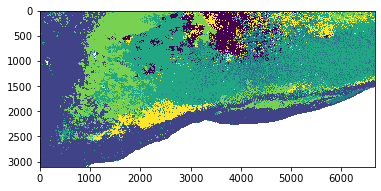

In [38]:
# visualize the 2D array 
cmap = plt.cm.viridis
cmap.set_bad(color='white')
plt.imshow(np.ma.masked_where(preds_reshaped == export_raster_nan, preds_reshaped), interpolation='nearest',cmap=cmap)
plt.show()

In [27]:
# write out the 2D array file to disk
with rasterio.Env():
    with rasterio.open(output_raster_file, 'w', **raster_meta) as dst:
        dst.write(preds_reshaped.astype(data_dtype), 1)